In [1]:
!nvidia-smi

Tue Jan 12 17:58:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   31C    P8     7W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
|ERR!   

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/tensorflow/

In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

False

In [3]:
import os
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [5]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2021-04-08


In [6]:
!pip install sodapy

In [7]:
from sodapy import Socrata

In [8]:
!mkdir data_flow

mkdir: data_flow: File exists


In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [10]:
#Flow

In [11]:
#https://flowmaps.life.bsc.es/flowboard/static/js/mobility.js
province_id_to_name = {'17': 'Girona', '43': 'Tarragona','08': 'Barcelona', '25': 'Lleida'}

In [12]:
#FLOW-Maps end-points

URL_IN_CCAA = "https://flowmaps.life.bsc.es/api/total_incoming_daily_mobility"
URL_OUT_CCAA = "https://flowmaps.life.bsc.es/api/total_outgoing_daily_mobility" 

INCID_CAT = "https://flowmaps.life.bsc.es/api/incidence" 
URL_RISK_CCAA = "https://flowmaps.life.bsc.es/api/incoming_risk_history/"

In [13]:
#Cases

In [14]:
payload = {"where":"{\"ev\":\"ES.covid_cpro\",\"start_date\":\"2020-01-01\",\"end_date\":\"" + today + "\"}"}
response = requests.get(INCID_CAT, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
print(response.url)

#dfCases["date"] = pd.to_datetime(dfCases["date"])
#dfCases.to_csv("data_flow/cases.csv",index=False)

https://flowmaps.life.bsc.es/api/incidence?where=%7B%22ev%22%3A%22ES.covid_cpro%22%2C%22start_date%22%3A%222020-01-01%22%2C%22end_date%22%3A%222021-04-08%22%7D


In [15]:
print(len(response.json()["_items"]))

dfCases = []
for i,row in enumerate(response.json()["_items"]):
    date = row.get("_id")
    
    dfDaily = pd.DataFrame(row.get("data"))

    dfRow = pd.DataFrame(np.array([date, 
     dfDaily.loc[dfDaily["id"]=="08"]["new_cases"].values[0], 
     dfDaily.loc[dfDaily["id"]=="17"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="43"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="25"]["new_cases"].values[0],
    ]).reshape(1,5), columns=["date","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"])
    dfCases.append(dfRow)

dfCases = pd.concat(dfCases)
print(len(dfCases))

463
463


In [16]:
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)
dfCases.to_csv("data_flow/cases_CAT_" + today + ".csv",index=False)

In [17]:
#Risk  (Sometimes fails, repeat until it works!)

In [20]:
dfInRisk=[]
for j,val in enumerate(province_id_to_name.keys()):
    payload = {"where":"{\"target\":\"" + val + "\",\"source_layer\":\"cnig_provincias\",\"target_layer\":\"cnig_provincias\",\"ev\":\"ES.covid_cpro\",\"total\":true}"}
    response = requests.get(URL_RISK_CCAA, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
    print(response.url)
    df = pd.DataFrame(response.json()["_items"])
    print("CCAA:", val,df.shape)
    
    if len(dfInRisk) == 0:
        dfInRisk = df
        dfInRisk["inrisk_"+val] = dfInRisk["incoming_risk"]
        dfInRisk.date = pd.to_datetime(dfInRisk.date)
        dfInRisk = dfInRisk[["date","inrisk_"+val]]
    else:
        df["inrisk_"+val] = df["incoming_risk"]
        df.date = pd.to_datetime(df.date)
        df = df[["date","inrisk_"+val]]
        dfInRisk = pd.merge(dfInRisk,df,on="date",suffixes=('',''))#,left_index=False,right_index=False) 

#Save
dfInRisk.to_csv("data_flow/inrisk_CAT_" + today + ".csv",index=False)

https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2217%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 17 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2243%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 43 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2208%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 08 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2225%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CC

In [21]:
#UCI

#https://analisi.transparenciacatalunya.cat/Salut/Dades-setmanals-de-COVID-19-per-rees-de-gesti-assi/k7cw-sg3w
#https://analisi.transparenciacatalunya.cat/Salut/Dades-di-ries-de-COVID-19-per-comarca/c7sd-zy9j
#https://dev.socrata.com/foundry/analisi.transparenciacatalunya.cat/623z-r97q
#https://dadescovid.cat/static/csv/ingressats_UCI.zip

In [22]:
#public: 3j6279557pu3y7q9eb8q9hfpw
#secret: 2uze9rhfcwodupxz8saonaiy56kmc5updhj5uz3u5kqbfagox6

In [23]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2021-04-08


In [24]:
#today = "2021-02-04"

In [25]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("c7sd-zy9j",limit=500000) #623z-r97q

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
print(results_df.shape)

(152334, 13)


In [155]:
#save
results_df["data"] = pd.to_datetime(results_df["data"])

print(results_df.columns)

results_df["ingressats_critic"] = pd.to_numeric(results_df["ingressats_critic"])
results_df["ingressos_critic"] = pd.to_numeric(results_df["ingressos_critic"])
results_df["ingressats_critic_all"] = results_df["ingressats_critic"] + results_df["ingressos_critic"]
results_df["ingressats_critic_all"] = pd.to_numeric(results_df["ingressats_critic_all"])

#results_df.sort_values("data",ascending=True).tail()
dfUCI = results_df[["data","ingressats_critic_all"]].groupby("data").sum()
print(dfUCI.columns)
dfUCI["uci"] = dfUCI
dfUCI["date"] = dfUCI.index.values

dfUCI = dfUCI[["date","uci"]]
dfUCI["date"] = pd.to_datetime(dfUCI["date"])
dfUCI.reset_index(drop=True, inplace=True)
dfUCI.to_csv("data_flow/UCI_CAT_" + today +".csv",index=False)

dfUCI.iloc[60:]

Index(['nom', 'codi', 'data', 'sexe', 'grup_edat', 'residencia',
       'casos_confirmat', 'pcr', 'ingressos_total', 'ingressos_critic',
       'ingressats_total', 'ingressats_critic', 'exitus',
       'ingressats_critic_all'],
      dtype='object')
Index(['ingressats_critic_all'], dtype='object')


,date,uci
60,2020-04-30,0
61,2020-05-01,406
62,2020-05-02,491
63,2020-05-03,466
64,2020-05-04,405
...,...,...
398,2021-04-03,373
399,2021-04-04,372
400,2021-04-05,385
401,2021-04-06,419


<AxesSubplot:>

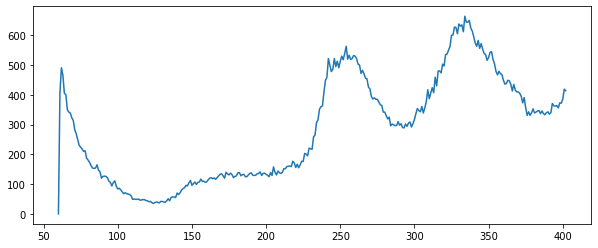

In [156]:
dfUCI.iloc[60:,1].plot(figsize=(10,4))

In [157]:
#Merge, remove null and na imputation

In [158]:
#Risk

In [159]:
#today = "2021-02-04" #"2021-01-26"

In [160]:
dfInRisk = pd.read_csv("data_flow/inrisk_CAT_" + today +".csv")

for i,col in enumerate(dfInRisk.columns):
    if i==0:
        dfInRisk[col] = pd.to_datetime(dfInRisk[col])
    else:
        dfInRisk[col] = pd.to_numeric(dfInRisk[col])

dfInRisk.sort_values("date",ascending=True, inplace=True)
dfInRisk["risk_BCN"] = dfInRisk["inrisk_08"]
dfInRisk["risk_GI"] = dfInRisk["inrisk_17"]
dfInRisk["risk_TAR"] = dfInRisk["inrisk_43"]
dfInRisk["risk_LLE"] = dfInRisk["inrisk_25"]
dfInRisk = dfInRisk[["date","risk_BCN","risk_GI","risk_LLE","risk_TAR"]]

print(dfInRisk.shape)
print(dfInRisk.columns)
print(dfInRisk["date"].iloc[:5])

(398, 5)
Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')
0   2020-02-15
1   2020-02-16
2   2020-02-17
3   2020-02-18
4   2020-02-19
Name: date, dtype: datetime64[ns]


In [161]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfInRisk.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfInRisk.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInRisk.iloc[i-j,k]
        zn.append(acc/7)

    dfInRisk[cols[k] + "_7"] = zn
    
    #plot
    #plt.figure(figsize=(10,4))    
    #ax = plt.subplot(1,2,1)
    #dfInRisk[["mean"]].plot(ax=ax)
    #ax = plt.subplot(1,2,2)
    #dfInRisk[["mean_7"]].plot(ax=ax)    
    #plt.show()
    #break
    
dfInRisk = dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]]
dfInRisk

Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')


,date,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7
0,2020-02-15,0.072949,0.151855,0.043482,0.102327
1,2020-02-16,0.143009,0.275563,0.075502,0.181203
2,2020-02-17,0.209083,0.381742,0.108660,0.260290
3,2020-02-18,0.279912,0.493185,0.143284,0.343318
4,2020-02-19,0.354539,0.602402,0.179170,0.428768
...,...,...,...,...,...
393,2021-03-15,233.164241,139.886954,68.189382,106.805224
394,2021-03-16,236.433578,141.618732,67.897175,107.619623
395,2021-03-17,239.146147,142.808721,67.415143,107.477465
396,2021-03-18,243.235773,144.220018,66.966612,108.520669


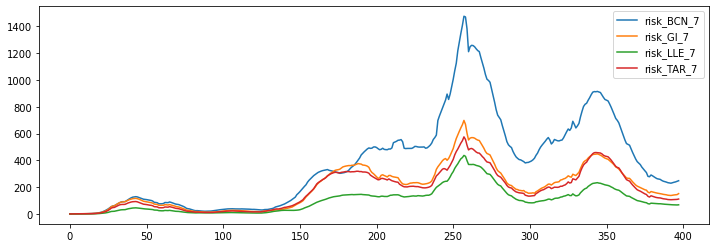

In [162]:
dfInRisk[["risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]].plot(figsize=(12,4))
plt.show()

In [163]:
#Cases

In [164]:
dfCases = pd.read_csv("data_flow/cases_CAT_" + today + ".csv")
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)

#Aggregate
dfCases["new_cases"] = np.nansum(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']],axis=1)
#dfCases["new_cases_mean"] = np.nanmean(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_std"] = np.nanstd(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_min"] = np.nanmin(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_max"] = np.nanmax(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)

dfCases = dfCases[["date","new_cases","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"]]
dfCases["total_cases"] = np.cumsum(dfCases["new_cases"].values)
print(dfCases.shape,dfCases.columns)

(463, 7) Index(['date', 'new_cases', 'new_cases_BCN', 'new_cases_GI', 'new_cases_TAR',
       'new_cases_LLE', 'total_cases'],
      dtype='object')


In [165]:
cols = dfCases.columns
for k in range(1,len(cols)):
    zn = []
    for i in range(dfCases.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfCases.iloc[i-j,k]
        zn.append(acc/7)

    dfCases[cols[k] + "_7"] = zn

dfCases

,date,new_cases,new_cases_BCN,new_cases_GI,new_cases_TAR,new_cases_LLE,total_cases,new_cases_7,new_cases_BCN_7,new_cases_GI_7,new_cases_TAR_7,new_cases_LLE_7,total_cases_7
0,2020-01-01,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-02,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-03,0,0,0,0,1,0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
3,2020-01-04,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
4,2020-01-05,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,2021-04-03,425,318,53,54,71,500669,867.714286,694.142857,120.000000,53.571429,109.428571,498511.714286
459,2021-04-04,288,204,43,41,51,500957,797.857143,641.428571,103.857143,52.571429,102.857143,499309.571429
460,2021-04-05,181,130,29,22,36,501138,636.714286,504.428571,85.571429,46.714286,85.142857,499946.285714
461,2021-04-06,165,127,34,4,6,501303,491.571429,384.857143,67.857143,38.857143,69.285714,500437.857143


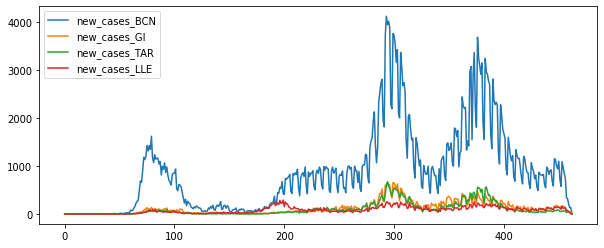

In [166]:
dfCases[["new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"]].plot(figsize=(10,4))
plt.show()

Index(['date', 'uci'], dtype='object')


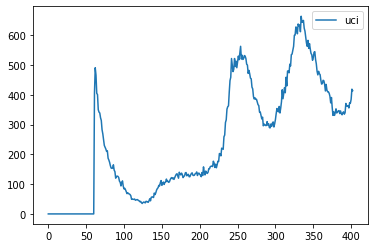

In [167]:
dfUCI = pd.read_csv("data_flow/UCI_CAT_" + today +".csv")
print(dfUCI.columns)
dfUCI.plot()
dfUCI["date"] = pd.to_datetime(dfUCI["date"])

In [168]:
#Merge cases
dfAll = pd.merge(dfCases[["date","new_cases","total_cases","new_cases_7",
                         "new_cases_GI_7","new_cases_LLE_7","new_cases_BCN_7","new_cases_TAR_7"]],
                 dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]], 
                 how="left",on="date")
dfAll["date"] = pd.to_datetime(dfAll["date"])

#Merge with UCI
dfAll = pd.merge(dfAll, dfUCI, how="left",on="date")
dfAll["date"] = pd.to_datetime(dfAll["date"])
dfAll["uci"] = pd.to_numeric(dfAll["uci"])

print(dfAll.shape)
print(dfAll.isnull().sum())
dfAll.iloc[50:150]

(463, 13)
date                0
new_cases           0
total_cases         0
new_cases_7         0
new_cases_GI_7      0
new_cases_LLE_7     0
new_cases_BCN_7     0
new_cases_TAR_7     0
risk_BCN_7         65
risk_GI_7          65
risk_LLE_7         65
risk_TAR_7         65
uci                60
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7,uci
50,2020-02-20,11,70,4.857143,0.000000,0.000000,4.857143,0.000000,0.442276,0.754779,0.225045,0.538895,NaN
51,2020-02-21,17,87,7.142857,0.142857,0.000000,6.857143,0.142857,0.553072,1.005390,0.311428,0.726526,NaN
52,2020-02-22,10,97,6.857143,0.285714,0.142857,6.285714,0.285714,0.612280,1.147988,0.347953,0.845117,NaN
53,2020-02-23,8,105,7.571429,0.428571,0.142857,6.857143,0.285714,0.789293,1.276407,0.383918,0.935209,NaN
54,2020-02-24,10,115,8.857143,0.571429,0.142857,7.857143,0.428571,0.995924,1.403718,0.427314,1.039668,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2020-05-25,206,50957,187.428571,17.714286,24.714286,165.714286,4.000000,34.413628,21.219058,9.969720,18.252280,154.0
146,2020-05-26,197,51154,186.571429,17.714286,23.428571,164.571429,4.285714,35.716813,22.463558,10.206906,19.655537,165.0
147,2020-05-27,145,51299,181.428571,17.857143,23.142857,159.571429,4.000000,36.723027,23.799491,10.340238,20.536192,147.0
148,2020-05-28,197,51496,178.142857,18.142857,23.142857,156.857143,3.142857,37.531106,24.906303,10.433040,21.192392,142.0


In [169]:
#Remove days without mobility index 
dfAll = dfAll.iloc[121:]

#Remove last day 
dfAll = dfAll.iloc[:-3]

dfAll.reset_index(inplace=True, drop=True)
#Na inputation
#dfAll.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True, order=2)

print(dfAll.shape)
print(dfAll.isnull().sum())
dfAll.tail()

(339, 13)
date                0
new_cases           0
total_cases         0
new_cases_7         0
new_cases_GI_7      0
new_cases_LLE_7     0
new_cases_BCN_7     0
new_cases_TAR_7     0
risk_BCN_7         17
risk_GI_7          17
risk_LLE_7         17
risk_TAR_7         17
uci                 0
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7,uci
334,2021-03-31,1062,498924,1102.714286,148.285714,130.428571,889.714286,64.714286,NaN,NaN,NaN,NaN,362.0
335,2021-04-01,906,499830,1063.714286,142.571429,127.571429,860.428571,60.714286,NaN,NaN,NaN,NaN,364.0
336,2021-04-02,414,500244,935.714286,130.285714,117.142857,752.142857,53.285714,NaN,NaN,NaN,NaN,356.0
337,2021-04-03,425,500669,867.714286,120.000000,109.428571,694.142857,53.571429,NaN,NaN,NaN,NaN,373.0
338,2021-04-04,288,500957,797.857143,103.857143,102.857143,641.428571,52.571429,NaN,NaN,NaN,NaN,372.0


In [170]:
#Na inputation
dfAll.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True, order=2)
print(dfAll.isnull().sum())
dfAll.tail(10)

date               0
new_cases          0
total_cases        0
new_cases_7        0
new_cases_GI_7     0
new_cases_LLE_7    0
new_cases_BCN_7    0
new_cases_TAR_7    0
risk_BCN_7         0
risk_GI_7          0
risk_LLE_7         0
risk_TAR_7         0
uci                0
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7,uci
329,2021-03-26,1310,493694,1146.285714,141.000000,126.285714,937.857143,67.428571,247.938432,151.411235,68.042877,111.186248,343.0
330,2021-03-27,901,494595,1157.857143,145.142857,130.428571,944.285714,68.428571,247.938432,151.411235,68.042877,111.186248,335.0
331,2021-03-28,777,495372,1164.714286,153.857143,132.285714,943.000000,67.857143,247.938432,151.411235,68.042877,111.186248,340.0
332,2021-03-29,1309,496681,1154.142857,153.285714,134.714286,934.428571,66.428571,247.938432,151.411235,68.042877,111.186248,371.0
333,2021-03-30,1181,497862,1128.571429,152.714286,131.714286,911.142857,64.714286,247.938432,151.411235,68.042877,111.186248,363.0
334,2021-03-31,1062,498924,1102.714286,148.285714,130.428571,889.714286,64.714286,247.938432,151.411235,68.042877,111.186248,362.0
335,2021-04-01,906,499830,1063.714286,142.571429,127.571429,860.428571,60.714286,247.938432,151.411235,68.042877,111.186248,364.0
336,2021-04-02,414,500244,935.714286,130.285714,117.142857,752.142857,53.285714,247.938432,151.411235,68.042877,111.186248,356.0
337,2021-04-03,425,500669,867.714286,120.000000,109.428571,694.142857,53.571429,247.938432,151.411235,68.042877,111.186248,373.0
338,2021-04-04,288,500957,797.857143,103.857143,102.857143,641.428571,52.571429,247.938432,151.411235,68.042877,111.186248,372.0


In [171]:
#Convert data to format (rows,timepoints,features)
cols = [
         #'total_cases',
         'new_cases',
         'new_cases_7',
         'new_cases_GI_7',
         'new_cases_TAR_7',
         'new_cases_BCN_7',
         'new_cases_LLE_7',    
         'risk_BCN_7',
         'risk_GI_7',
         'risk_LLE_7',
         'risk_TAR_7',
         'uci'
]

In [172]:
fname = "best_model_uci_CAT_7to21ahead_1"

In [173]:
#Forecasting future!!

In [174]:
res_test = series_to_supervised(dfAll.loc[:,cols].values,7,21,dropnan=False)
print(cols)
res_test.shape

['new_cases', 'new_cases_7', 'new_cases_GI_7', 'new_cases_TAR_7', 'new_cases_BCN_7', 'new_cases_LLE_7', 'risk_BCN_7', 'risk_GI_7', 'risk_LLE_7', 'risk_TAR_7', 'uci']


(339, 308)

In [175]:
#Find rows for future pred
ftest_X = res_test.iloc[-1,:77].values.reshape(-1,7,11)
ftest_y = res_test.iloc[-1,[87+(11*i) for i in range(21)]].values.reshape(-1,21)

print(ftest_X.shape, ftest_y.shape)
print(ftest_y[0,:])

(1, 7, 11) (1, 21)
[372.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan]


In [176]:
from pickle import load

# normalize features
for i in range(ftest_X.shape[-1]):

    # normalize features
    scalers_X = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))

    ftest_X[:,:,i] = scalers_X.transform(ftest_X[:,:,i])

print(ftest_X.shape)
print(np.nanmax(ftest_X),np.nanmin(ftest_X),np.nanmean(ftest_X),np.nanstd(ftest_X))

(1, 7, 11)
0.6401515151515151 0.06385118149824033 0.23338391734148342 0.154211569816922


/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.20.4 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.20.4 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.20.4 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.20.4 when using version 0.22.1. This might lea

In [177]:
#Forecasting last X days for all models

In [178]:
scaler_y = load(open("models/"+ fname + "_scaler_tr_Y.pkl", 'rb'))

all_preds = []
for i in range(10):
    print("\nLoading model:", i)
    model = tf.keras.models.load_model("models/"+ fname + "_" + str(i) +'.h5')
    preds = model.predict(ftest_X)
    preds_inv = scaler_y.inverse_transform(preds)
    print(len(preds_inv), np.max(preds_inv), np.min(preds_inv))
    print(preds_inv.shape)
    all_preds.append(preds_inv)

/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.20.4 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)



Loading model: 0
1 314.5037 249.97139
(1, 21)

Loading model: 1
1 323.52982 233.5084
(1, 21)

Loading model: 2
1 303.36636 252.04721
(1, 21)

Loading model: 3
1 325.7163 246.65186
(1, 21)

Loading model: 4
1 313.14383 249.30988
(1, 21)

Loading model: 5
1 325.47537 240.45123
(1, 21)

Loading model: 6
1 300.0871 257.8806
(1, 21)

Loading model: 7
1 311.48157 250.91951
(1, 21)

Loading model: 8
1 312.2046 241.16096
(1, 21)

Loading model: 9
1 318.1156 244.49164
(1, 21)


In [179]:
all_preds_aux = np.stack((all_preds))
print(all_preds_aux.shape)

all_preds_aux[:,-1,:].mean(axis=0)
all_preds_aux[:,-1,:].std(axis=0)

(10, 1, 21)


array([ 8.346953 ,  9.474658 ,  6.1930885,  7.426537 ,  5.1923656,
        6.4504056,  5.795384 ,  6.5923862,  5.511749 ,  4.156063 ,
        5.026749 ,  5.024558 ,  4.4971614,  4.439303 ,  4.6769505,
        5.658545 ,  6.5746303,  9.55831  , 10.424644 ,  9.419985 ,
       10.227023 ], dtype=float32)

In [145]:
all_res = all_preds_aux[:,:all_preds_aux.shape[1]]
for i in range(all_preds_aux.shape[1]-1,19,-1):
    all_res = np.hstack((all_preds_aux[:,i,-1].reshape(10,1),all_res))

all_res = np.array(all_res)
print(all_res.shape)

(10, 1, 21)


In [146]:
dfPreds = pd.DataFrame(np.hstack((all_res)).astype(int).reshape(10,21),
                       columns=["d"+str(i) for i in range(21)])
dfPreds.astype(int).to_csv("preds_icu_21days_7tp_"+today+".csv",index=False)
dfPreds.describe().T

,count,mean,std,min,25%,50%,75%,max
d0,10.0,83.7,10.995454,69.0,75.25,82.5,90.75,101.0
d1,10.0,84.2,12.865112,64.0,75.25,82.0,94.50,103.0
d2,10.0,86.6,12.720936,65.0,79.25,84.0,96.00,105.0
d3,10.0,89.6,12.606876,69.0,81.75,88.5,97.50,108.0
d4,10.0,91.7,12.284136,70.0,84.25,90.0,101.75,110.0
d5,10.0,94.7,13.573258,71.0,88.75,93.0,106.00,113.0
d6,10.0,97.0,13.333333,73.0,90.00,95.0,107.50,116.0
d7,10.0,101.6,12.167352,79.0,94.75,101.5,109.75,119.0
d8,10.0,106.1,12.031902,81.0,102.25,105.0,113.25,123.0
d9,10.0,110.1,12.896597,83.0,106.00,108.5,118.50,130.0


In [147]:
import datetime
import matplotlib.dates as mdates
date_time_str = '2021-04-05'
base = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
date_list = [base + datetime.timedelta(days=x) for x in range(21)]
date_list

[datetime.datetime(2021, 4, 5, 0, 0),
 datetime.datetime(2021, 4, 6, 0, 0),
 datetime.datetime(2021, 4, 7, 0, 0),
 datetime.datetime(2021, 4, 8, 0, 0),
 datetime.datetime(2021, 4, 9, 0, 0),
 datetime.datetime(2021, 4, 10, 0, 0),
 datetime.datetime(2021, 4, 11, 0, 0),
 datetime.datetime(2021, 4, 12, 0, 0),
 datetime.datetime(2021, 4, 13, 0, 0),
 datetime.datetime(2021, 4, 14, 0, 0),
 datetime.datetime(2021, 4, 15, 0, 0),
 datetime.datetime(2021, 4, 16, 0, 0),
 datetime.datetime(2021, 4, 17, 0, 0),
 datetime.datetime(2021, 4, 18, 0, 0),
 datetime.datetime(2021, 4, 19, 0, 0),
 datetime.datetime(2021, 4, 20, 0, 0),
 datetime.datetime(2021, 4, 21, 0, 0),
 datetime.datetime(2021, 4, 22, 0, 0),
 datetime.datetime(2021, 4, 23, 0, 0),
 datetime.datetime(2021, 4, 24, 0, 0),
 datetime.datetime(2021, 4, 25, 0, 0)]

In [148]:
dfPreds = pd.read_csv("preds_icu_21days_7tp_"+today+".csv").astype(int)
dfPreds.describe().T

,count,mean,std,min,25%,50%,75%,max
d0,10.0,83.7,10.995454,69.0,75.25,82.5,90.75,101.0
d1,10.0,84.2,12.865112,64.0,75.25,82.0,94.50,103.0
d2,10.0,86.6,12.720936,65.0,79.25,84.0,96.00,105.0
d3,10.0,89.6,12.606876,69.0,81.75,88.5,97.50,108.0
d4,10.0,91.7,12.284136,70.0,84.25,90.0,101.75,110.0
d5,10.0,94.7,13.573258,71.0,88.75,93.0,106.00,113.0
d6,10.0,97.0,13.333333,73.0,90.00,95.0,107.50,116.0
d7,10.0,101.6,12.167352,79.0,94.75,101.5,109.75,119.0
d8,10.0,106.1,12.031902,81.0,102.25,105.0,113.25,123.0
d9,10.0,110.1,12.896597,83.0,106.00,108.5,118.50,130.0


In [149]:
dfPredsT = dfPreds.T
dfPredsT.reset_index(drop=True, inplace=True)
dfPredsT["date"] = date_list
#dfPredsT["date"] = pd.to_datetime(dfPredsT["date"])
#dfPredsT.index = dfPredsT["date"]
#dfPredsT = dfPredsT[[i for i in range(10)]]
dfPredsT.head()

,0,1,2,3,4,5,6,7,8,9,date
0,91,101,69,82,72,90,76,83,75,98,2021-04-05
1,97,103,64,84,73,87,80,74,79,101,2021-04-06
2,98,105,65,84,77,90,80,79,84,104,2021-04-07
3,100,108,69,89,79,90,84,81,88,108,2021-04-08
4,105,110,70,92,83,90,88,83,90,106,2021-04-09


In [150]:
print(dfPredsT[[i for i in range(10)]].mean(axis=1).mean(axis=0))
print(dfPredsT[[i for i in range(10)]].mean(axis=1).std(axis=0))

118.60000000000002
27.560515234661345


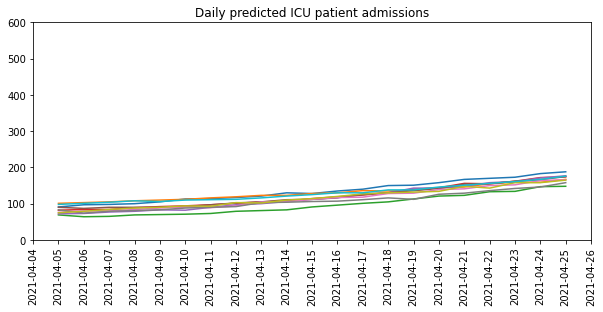

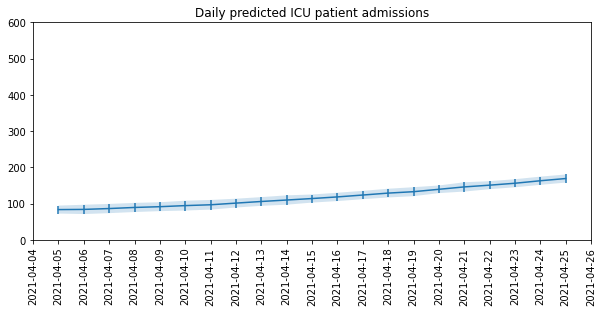

In [151]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.plot(dfPredsT["date"], dfPredsT[[i for i in range(10)]])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.errorbar(dfPredsT["date"], 
            dfPredsT[[i for i in range(10)]].mean(axis=1),
            yerr=dfPredsT[[i for i in range(10)]].std(axis=1))
ax.fill_between(dfPredsT["date"],
                dfPredsT[[i for i in range(10)]].mean(axis=1)-dfPredsT[[i for i in range(10)]].std(axis=1),
                dfPredsT[[i for i in range(10)]].mean(axis=1)+dfPredsT[[i for i in range(10)]].std(axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.show()

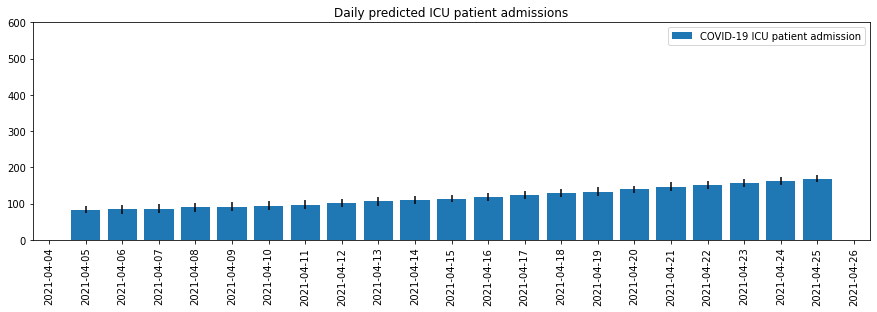

In [152]:
plt.figure(figsize=(15,4))
ax = plt.subplot(1,1,1)
ax.bar(dfPredsT["date"].values, np.mean(dfPredsT[[i for i in range(10)]], axis=1), 
            yerr=np.std(dfPredsT[[i for i in range(10)]], axis=1), label="COVID-19 ICU patient admission")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [153]:
np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)

0       83.7
1      167.9
2      254.5
3      344.1
4      435.8
5      530.5
6      627.5
7      729.1
8      835.2
9      945.3
10    1059.5
11    1178.2
12    1302.1
13    1431.3
14    1564.4
15    1704.1
16    1850.4
17    2001.5
18    2157.9
19    2321.2
20    2490.6
dtype: float64

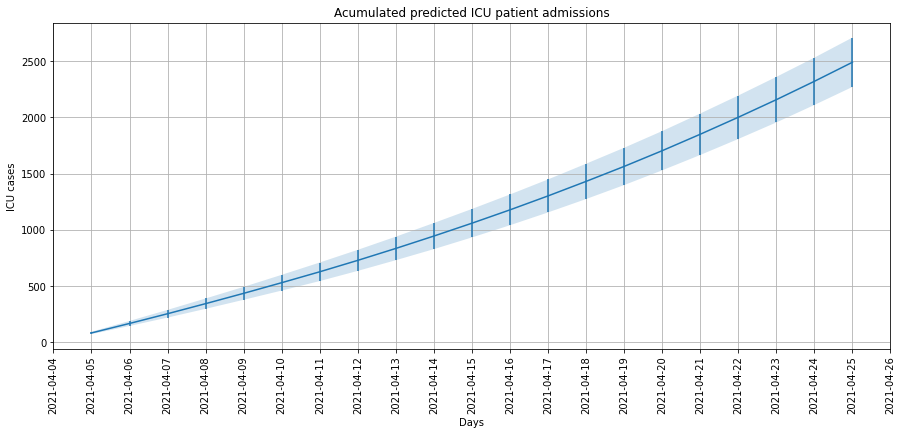

In [154]:
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
ax.errorbar(dfPredsT["date"], np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
        yerr=np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1))
ax.fill_between(dfPredsT["date"],
                np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)-np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
                np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)+np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Acumulated predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.ylabel("ICU cases")
plt.xlabel("Days")
plt.grid()
plt.show()